In [1]:
%matplotlib inline
from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac, unweighted_unifrac_fast, weighted_unifrac_fast
import pandas as pd
from qiime_default_reference import get_reference_tree
from skbio import TreeNode
from skbio.diversity._fast_base import index_tree
from biom import load_table
from skbio.diversity.beta._fast_unifrac import make_pdist, unifrac, w_unifrac
from skbio.diversity.beta import pw_distances
import numpy as np

np.random.seed(1234)

bench_data = load_table('data/AG_even10k.biom')
tree = TreeNode.read(get_reference_tree())

# correct a missing branchlength in the reference tree
for n in tree.traverse(include_self=False):
    if n.length is None:
        n.length = 0.0
        
def make_and_run_pw_distances(method, counts, otu_ids, tree, ids=None):
    metric, counts_array, length = make_pdist(counts, otu_ids, tree, metric=method)
    return pw_distances(metric, counts_array, ids=ids)

def get_random_samples(n, tree, shear):
    samples = bench_data.subsample(n, by_id=True)
    samples.filter(lambda v, i, md: v.sum() > 0, axis='observation')  # remove zero'd observations in place
    ids = samples.ids().copy()
    otu_ids = samples.ids(axis='observation').copy()
    otu_data = samples.matrix_data.toarray().T
    if shear:
        t = tree.shear(otu_ids)
    else:
        t = tree.copy()
        
    return ids, otu_ids, otu_data, t

Verify producing the sames results.

In [16]:
import numpy.testing as npt

ids, otu_ids, otu_data, t = get_random_samples(10, tree, True)

fu_mat = make_and_run_pw_distances(unifrac, otu_data, otu_ids=otu_ids, tree=t)
u_mat = pw_distances(unweighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)
fwu_mat = make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t)
wu_mat = pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)

npt.assert_almost_equal(fu_mat.data, u_mat.data)
npt.assert_almost_equal(fwu_mat.data, wu_mat.data)

General timing

In [17]:
%timeit make_and_run_pw_distances(unifrac, otu_data, otu_ids=otu_ids, tree=t)
%timeit pw_distances(unweighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)
%timeit make_and_run_pw_distances(w_unifrac, otu_data, otu_ids=otu_ids, tree=t)
%timeit pw_distances(weighted_unifrac, otu_data, otu_ids=otu_ids, tree=t)

10 loops, best of 3: 37 ms per loop
1 loops, best of 3: 1.47 s per loop
10 loops, best of 3: 46.8 ms per loop
1 loops, best of 3: 1.7 s per loop


API testing, making the same method calls and verifying results. Intentionally doing the full matrix in the (very unexpected event) that d(u, v) != d(v, u)

In [18]:
method_sets = [[unweighted_unifrac, unweighted_unifrac_fast], 
               [weighted_unifrac, weighted_unifrac_fast]]

ids, otu_ids, otu_data, t = get_random_samples(5, tree, True)

for i in range(len(otu_data)):
    for j in range(len(otu_data)):
        for method_set in method_sets:
            method_results = []
            for method in method_set:
                method_results.append(method(otu_data[i], otu_data[j], otu_ids, t))
            npt.assert_almost_equal(*method_results)

`pw_distances` scaling tests.

10 loops, best of 3: 22.2 ms per loop
10 loops, best of 3: 23.8 ms per loop
100 loops, best of 3: 10.3 ms per loop
100 loops, best of 3: 11.8 ms per loop
10 loops, best of 3: 137 ms per loop
10 loops, best of 3: 155 ms per loop
100 loops, best of 3: 17.5 ms per loop
10 loops, best of 3: 19.6 ms per loop
1 loops, best of 3: 1.33 s per loop
1 loops, best of 3: 1.5 s per loop
10 loops, best of 3: 55.3 ms per loop
10 loops, best of 3: 65.9 ms per loop
1 loops, best of 3: 4.62 s per loop
1 loops, best of 3: 5.2 s per loop
10 loops, best of 3: 54.9 ms per loop
10 loops, best of 3: 66.7 ms per loop
1 loops, best of 3: 21.8 s per loop
1 loops, best of 3: 24.2 s per loop
10 loops, best of 3: 107 ms per loop
10 loops, best of 3: 129 ms per loop
1 loops, best of 3: 1min 48s per loop
1 loops, best of 3: 1min 59s per loop
1 loops, best of 3: 348 ms per loop
1 loops, best of 3: 413 ms per loop


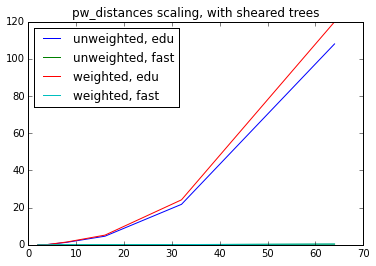

In [11]:
sample_counts = [2, 4, 8, 16, 32, 64]
uw_times = []
uwf_times = []
w_times = []
wf_times = []

for n_samples in sample_counts:
    ids, otu_ids, otu_data, t = get_random_samples(n_samples, tree, True)

    for times, method in [[uw_times, unweighted_unifrac], [w_times, weighted_unifrac]]:
        result = %timeit -o pw_distances(method, otu_data, otu_ids=otu_ids, tree=t)
        times.append(result.best)

    for times, method in [[uwf_times, unifrac], [wf_times, w_unifrac]]:
        result = %timeit -o make_and_run_pw_distances(method, otu_data, otu_ids=otu_ids, tree=t)
        times.append(result.best)     
plot(sample_counts, uw_times)
plot(sample_counts, uwf_times)
plot(sample_counts, w_times)
plot(sample_counts, wf_times)
legend(['unweighted, edu', 'unweighted, fast', 'weighted, edu', 'weighted, fast'], loc=0)
title("pw_distances scaling, with sheared trees")
xlabel('number of samples')
ylabel('time (seconds)')
xscale('log')
yscale('log')
savefig('edu vs fast.png')